## SMART TANKS
### Coupled tanks simulator based on machine learning

#### 1. Required functions

In [1]:
### FUNCTIONS

#function to scale the dataset
def scaleData(data):
    s_data = data.copy()
    l = len(s_data.T)
    for i in range(l):
        s_data.iloc[:,i] = ((data.iloc[:,i] - data.iloc[:,i].min())
                          / (data.iloc[:,i].max() - data.iloc[:,i].min()))
    return s_data

#function to standardize the dataset
def standardizeData(data):
    s_data = data.copy()
    l = len(s_data.T)
    for i in range(l):
        s_data.iloc[:,i] = ((data.iloc[:,i] - data.iloc[:,i].mean())
                          / data.iloc[:,i].std())
    
    return s_data

#function to reStand data
def reStandData(data,y,n_inputs,n_outputs):
    s_y = y.copy()
    outs = data.iloc[:,n_inputs:n_inputs+n_outputs]
    y_m = np.matrix(y)
    l = len(outs.T)
    for i in range(l):
        s_y = y_m[i,:] * outs.iloc[:,i].std() + outs.iloc[:,i].mean()
        
    
    return np.array(s_y)

#function to add previous values as features
def addFeatures(data, n, names):
    l = len(data.T)
    for i in range(l):
        for j in range(n):
            #names for delayed inputs
            #Ex: Input Gas Rate (-1)...
            txt = names[i]+' (-'+str(j+1)+')'
            if j == 0:
                data[txt] = data[names[i]].shift(periods=1)
            else:
                txt2 = names[i]+' (-'+str(j)+')'
                data[txt] = data[txt2].shift(periods=1)
            
            data.loc[0,txt] = data.loc[1,txt]
            
        
    
    return data


#split data into X and y
def getPairs(fData, n_inputs, n_outputs):
    x = fData.iloc[:,0:n_inputs]
    delayed_x = fData.iloc[:,n_inputs+n_outputs:]
    X = pd.concat([x,delayed_x], axis=1)
    y = fData.iloc[:,n_inputs:n_inputs+n_outputs]
    return X,y



from sklearn.model_selection import train_test_split

#getting (shuffled) train and test sets 
def getTrainTest(X,Y,samples_train=0.85, shuffle=0):
    if(shuffle):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1-samples_train,random_state=1)
        return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
    else:
        train_size = int(len(X) * samples_train)
        test_size = len(X) - train_size
        X_train, X_test = X.iloc[0:train_size],X.iloc[train_size:train_size+test_size]
        y_train, y_test = Y.iloc[0:train_size],Y.iloc[train_size:train_size+test_size]
        return X_train, X_test, y_train, y_test
    
def getTrainTestNoDF(X,Y,samples_train=0.85):
    train_size = int(len(X) * samples_train)
    test_size = len(X) - train_size
    X_train, X_test = X[0:train_size],X[train_size:train_size+test_size]
    y_train, y_test = Y[0:train_size],Y[train_size:train_size+test_size]
    return X_train, X_test, y_train, y_test

        
def plotOuts(y_pred, y_test, title):
    l = len(y_pred.T)
    for i in range(l):
        plt.figure(i)
        plt.plot(y_pred[:,i])
        plt.plot(y_test[:,i])
        plt.xlabel('Sample');


def getLearningCurve(history):
    plt.figure()
    plt.plot(history['loss'], label='train')
    plt.plot(history['val_loss'], label='test')
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

import pickle

def saveHistoryTrain(folder,name,emq,history,verbose=0):
    with open('models/'+str(folder)+'/histories/'+str(name)+'_'+str(emq), 'wb') as file_pi:
        pickle.dump(history, file_pi)
    if(verbose):    
        print("Histórico de trainamento salvo")
        
        
def loadHistoryTrain():
    history = pickle.load(open('models/histories/ST_'+str(best_ss['emq']), "rb"))
    return history

#### 2. Data preprocessing

In [76]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import scipy.stats as st
from pylab import rcParams
from matplotlib import rc
import time
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



###########
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16,10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
############

#path to access the dataset .txt or .csv
path = 'tankdata.csv'

#data from pandas
tankdata = pd.read_csv(path)
print(tankdata.shape)


#order of features
n_features = 6
n_inputs = 1
n_outputs = 1

#Adicionando features aos dados
fTD = addFeatures(tankdata, n_features, tankdata.columns)
X = fTD.iloc[:,2:]
y = tankdata.L2
print("Data shape: ",X.shape, y.shape)

#X_train = X[:46661]
#X_test = X[46662:]
#y_train = y[:46661]
#y_test = y[46662:]

#Segment the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
#Standardize the data set.
ss = StandardScaler()
#X_train = ss.fit_transform(X_train)
#X_test = ss.transform(X_test)


print("Supervised phase traning and test: (X)", X_train.shape, X_test.shape)
print("Traning and Test: (y)", y_train.shape, y_test.shape)


(93322, 2)
Data shape:  (93322, 12) (93322,)
Supervised phase traning and test: (X) (46661, 12) (46661, 12)
Traning and Test: (y) (46661,) (46661,)


### 3. Sklearn Models for regression

In [34]:
#Introduce algorithms.
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression, ElasticNet
#Compared with SVC, it is the regression form of SVM.
from sklearn.svm import SVR
#Integrate algorithms.
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

#Set the model name.
names = ['LinerRegression',
       'Ridge',
       'Lasso',
       'Random Forrest',
       'GBDT',
       'Support Vector Regression',
       'ElasticNet']

#Define the model.
# cv is the cross-validation idea here.
models = [LinearRegression(),
         RidgeCV(alphas=(0.001,0.1,1),cv=3),
         LassoCV(alphas=(0.001,0.1,1),cv=5),
         RandomForestRegressor(n_estimators=10),
         GradientBoostingRegressor(n_estimators=30),
         SVR(),
         ElasticNet(alpha=0.001,max_iter=10000)]
# Output the R2 scores of all regression models.

#Define the R2 scoring function.
def RMSE(model,x_train, x_test, y_train, y_test):

        model_fitted = model.fit(x_train,y_train)
        y_pred = model_fitted.predict(x_test)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        return score

#Traverse all models to score.
for name,model in zip(names,models):
        score = RMSE(model,X_train, X_test, y_train, y_test)
        print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LinerRegression: 0.022162, 0.0000
Ridge: 0.022162, 0.0000
Lasso: 0.024960, 0.0000
Random Forrest: 0.022873, 0.0000
GBDT: 0.407116, 0.0000
Support Vector Regression: 0.051145, 0.0000
ElasticNet: 0.024956, 0.0000


(46661, 12)
(46661,) (46661,)
(46661, 1) (46661, 1)


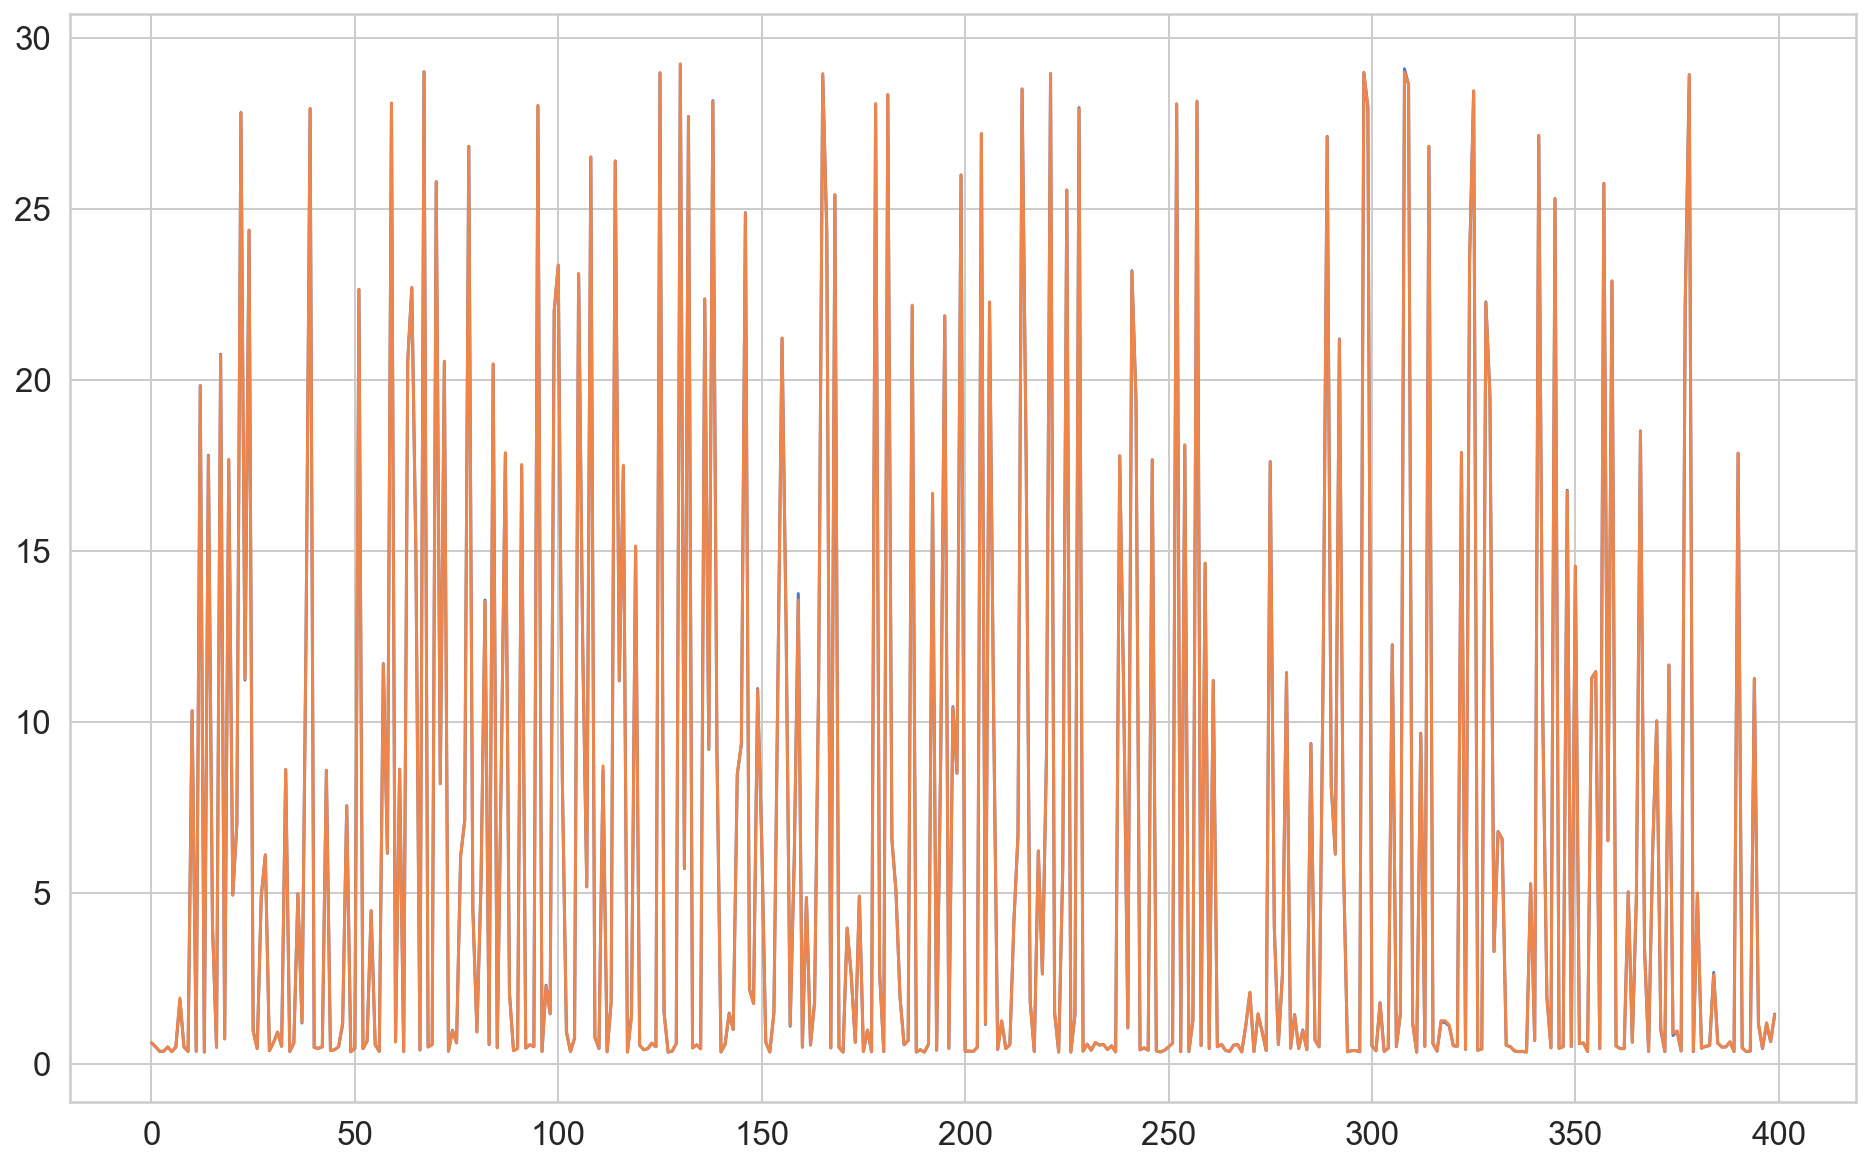

In [35]:
print(X_test.shape)
y_pred = models[0].predict(X_test)
print(y_pred.shape,y_test.shape)
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_test = np.array(y_test).reshape(y_pred.shape[0],1)
print(y_pred.shape,y_test.shape)

plt.plot(y_pred[:400])
plt.plot(y_test[:400])

[9.97791038]
10.011672973632812


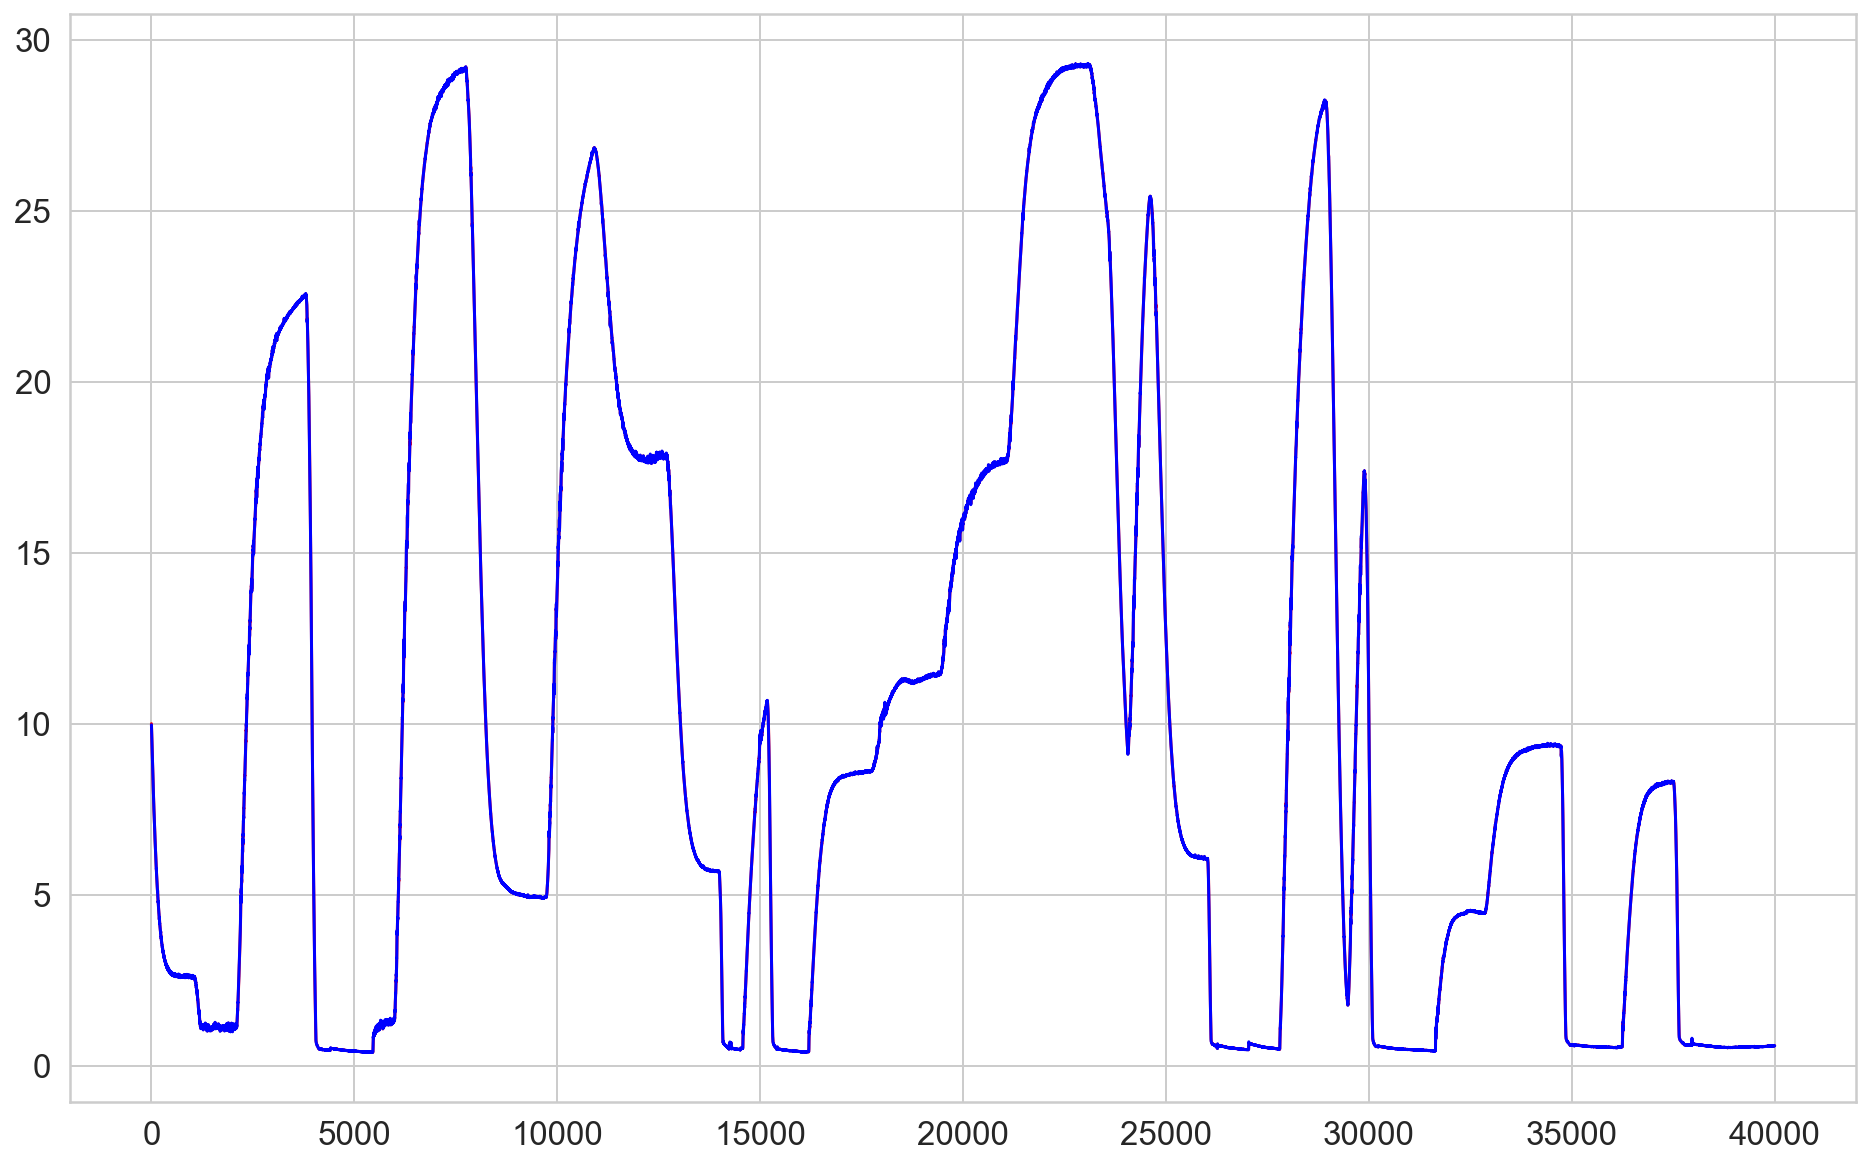

In [102]:
X_train = X[:X_test.shape[0]]
X_test = X[X_test.shape[0]+1:]
y_train = y[:X_test.shape[0]]
y_test = y[X_test.shape[0]+1:]

X_test = np.array(X_test)
y_test = np.array(y_test)


y_pred = models[0].predict(X_test)

plt.plot(y_test[:40000],color='red')
plt.plot(y_pred[:40000],color='blue')


x = X_test[0]
y_pred = models[0].predict(x.reshape(1,12))
print(y_pred)
print(y_test[0])




[0.41620156]
[0.40817261]


In [103]:
x = X_test[0]

n_updates = 10000
preds = list()

for j in range(n_updates):
    #print(x)
    if(j % 100 == 0):
        x = X_test[j]
    
    y_pred = models[1].predict(x.reshape(1,12))
    preds.append(y_pred)
    x[6:] = X_test[j+1,6:]
    new_x = y_pred
    aux = x[0] 
    x[0] = new_x
    for i in range(n_features-1):
        aux2 = x[i+1]
        x[i+1] = aux
        aux = aux2

print(preds[0],y_test[0])      
print(preds[1],y_test[1]) 
print(preds[2],y_test[2]) 
print(preds[3],y_test[3])      
print(preds[4],y_test[4]) 
print(preds[5],y_test[5]) 


[9.97791132] 10.011672973632812
[9.94629154] 9.967803955078123
[9.91581155] 9.923934936523438
[9.88865781] 9.876251220703123
[9.86424417] 9.828567504882812
[9.84319155] 9.784698486328123


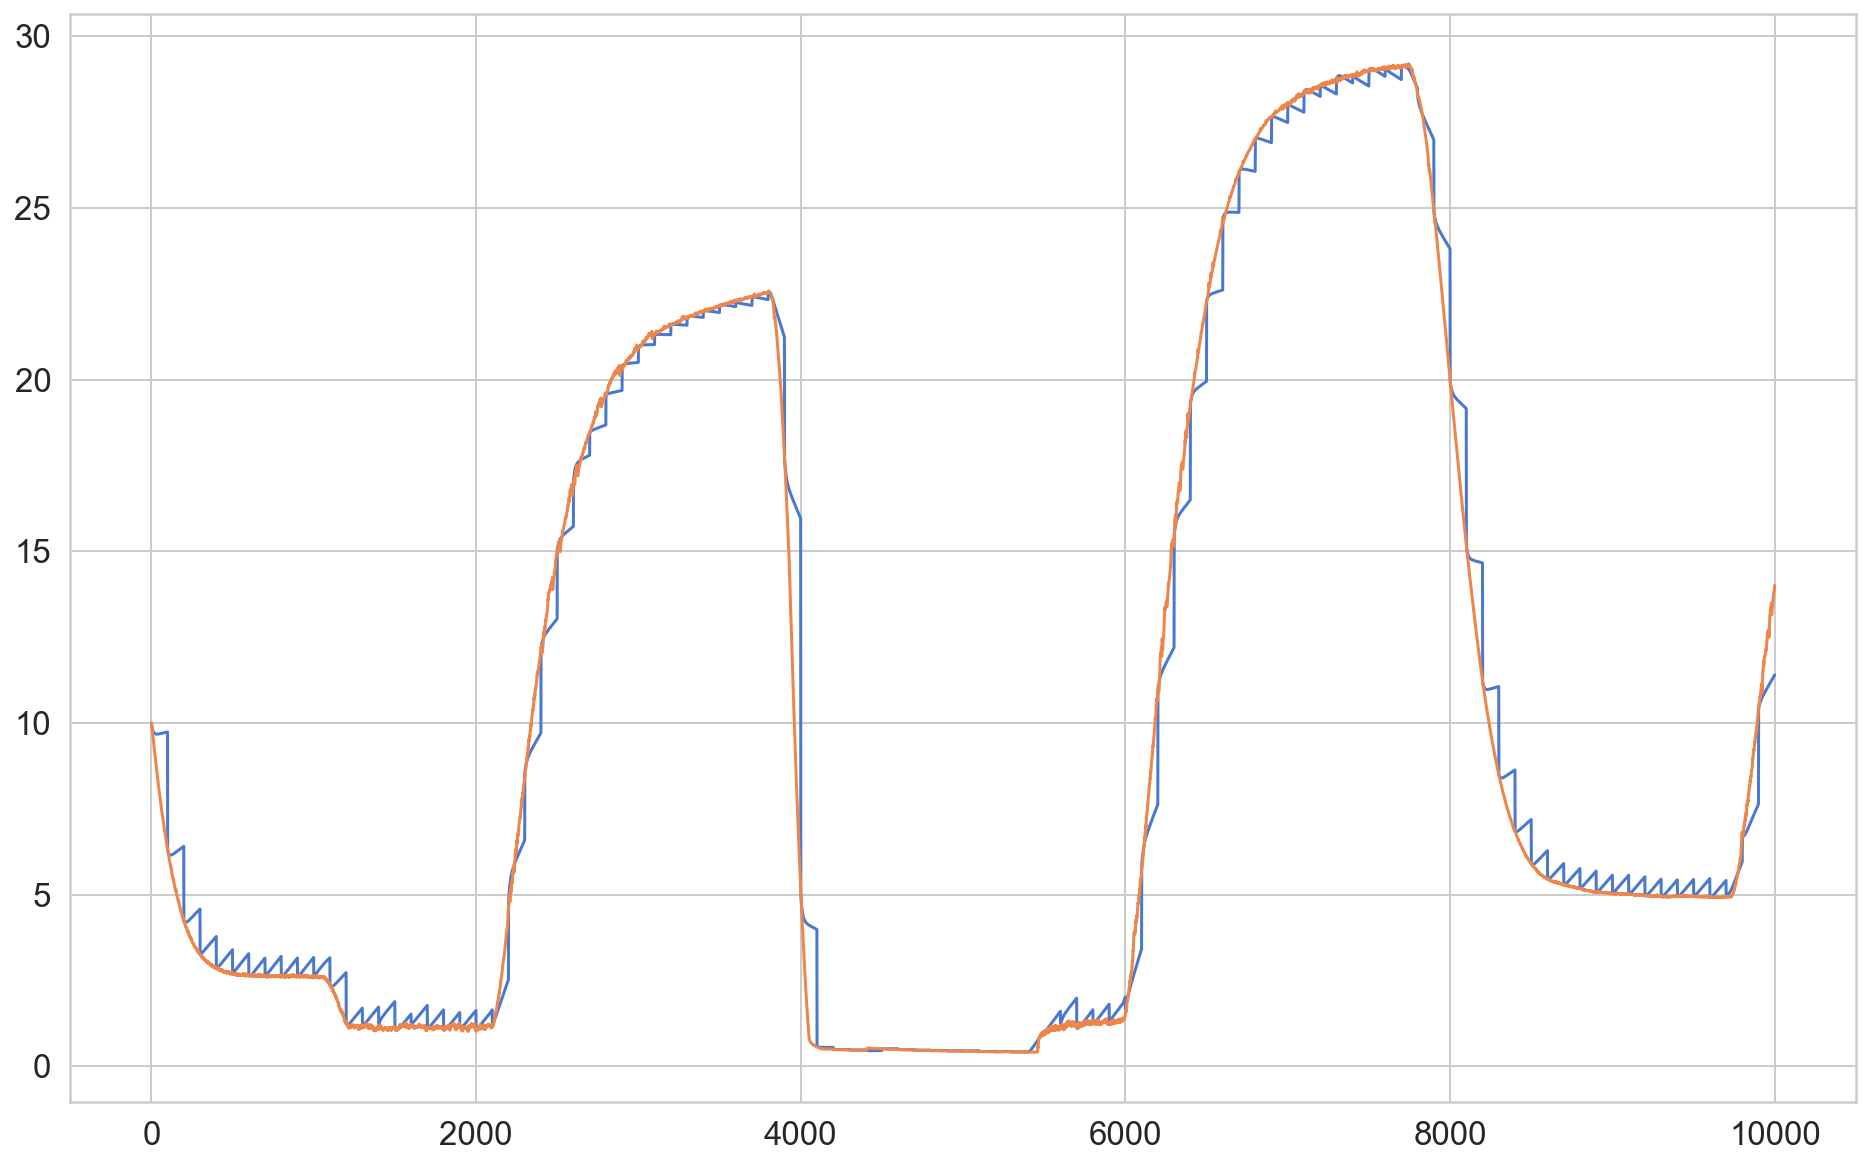

In [104]:
#preds = np.array(preds)
#print(preds.T)
#print(y_test[:n_updates])
plt.plot(preds[:10000])
plt.plot(y_test[:10000])

#### MLP

In [92]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping

features_size = X_train.shape[1]

nets = [];
histories_nets = [];
best_mlp = {'emq':10, 'index': 0}

loss = 'mean_squared_error'
n_neurons = 2
n_epochs = 40
learning_rate = 0.001
bs = 30
vs = 0.1
optimizer = keras.optimizers.Adam(learning_rate)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, 
                   baseline=None, restore_best_weights=True)
mape = tf.keras.losses.MeanAbsolutePercentageError()

n_nets = 7

for i in range(n_nets):
    n_neurons = 2*n_neurons
    input_l= Input(shape=(features_size,))
    HL1 = Dense(units=n_neurons, activation='relu')(input_l)
    output_l = Dense(units=n_outputs, activation='linear')(HL1)
    MLP=Model(input_l, output_l)
    nets.append(MLP)
    nets[i].compile(optimizer=optimizer, loss=loss)
    history = nets[i].fit(X_train, y_train,epochs=n_epochs,batch_size=bs,validation_split=vs,verbose=0,shuffle=True,callbacks=[es])
    histories_nets.append(history)
    local_y_pred = nets[i].predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, local_y_pred))
    if(rmse < best_mlp['emq']):
        best_mlp['emq'] = rmse
        best_mlp['index'] = i
    print("MLP-"+str(i)+" EMQ: ", rmse)
    
    
print(" ")
print("A melhor é MLP-"+str(best_mlp['index'])+" com RMSE: ", best_mlp['emq'])
getLearningCurve(histories_nets[best_mlp['index']])
#nets[best_mlp['index']].summary()
#nets[(best_mlp['index'])].save('models/supervised/mlp_'+str(best_mlp['emq']))

MLP-0 EMQ:  0.035985501743085305
MLP-1 EMQ:  0.03777667666074362


KeyboardInterrupt: 